# Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision datasets
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-b

In [ ]:
from datasets import load_dataset
import clip
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model, preprocess = clip.load("ViT-B/16", device = device, jit=False)

100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 98.6MiB/s]


In [ ]:
ds = load_dataset("aggr8/brain_mri_train_test_split")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/537 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/7.88M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
text_prompts = ["a photo of glioma tumor", "a photo of meningioma tumor", "a photo of no tumor", "a photo of pituitary tumor"]

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


class CustomImageDatasetTrain(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = clip.tokenize([text_prompts[label] for label in labels])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = preprocess(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transformations = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])



In [ ]:
dataset = CustomImageDatasetTrain(ds["train"]["image"], ds["train"]["label"], transform=transformations)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_dataset_2 = CustomImageDataset(ds["train"]["image"], ds["train"]["label"])
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=False)

In [ ]:
len(next(iter(train_dataloader)))

2

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
import numpy as np
import os

n_epochs = 40

train_acc = []
train_epoch = []
test_acc = []
train_loss = []


best_accuracy_sum = 0  # Variable to store the best combined accuracy
best_model_path = "/content/drive/My Drive/Data/COL828/full_finetune_best_model_3.pth"  # Path to save the best model


for epoch in range(n_epochs):
    pbar = tqdm(train_dataloader, total = len(train_dataloader))
    loss=0
    model.train()
    for batch in pbar:
        optimizer.zero_grad()
        images, texts = batch
        images, texts = images.to(device), texts.to(device)

        # forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # loss is avg of text and image loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth))/2

        total_loss.backward()
        # loss+=total_loss.item()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)
        optimizer.step()

        pbar.set_description(f"Epoch {epoch}/{n_epochs}, Loss: {total_loss.item():.4f}")

    train_epoch.append(epoch)
    train_loss.append(loss/len(train_dataloader))
    print(f"Epoch {epoch}/{n_epochs}, Loss: {loss/len(train_dataloader):.4f}")


    epoch_pred = []
    epoch_label = []
    with torch.no_grad():
        model.eval()
        for images, texts in tqdm(test_dataloader_2, desc="Testing"):
            images, texts = images.to(device), texts.to(device)
            input_text = clip.tokenize(text_prompts).to(device)



            # Forward pass (test mode)
            logits_per_image, logits_per_text = model(images, input_text)

            # Get predicted class (argmax over logits)
            preds = torch.argmax(logits_per_image, dim=1)

            epoch_pred.extend(preds.cpu().numpy())
            epoch_label.extend(texts.cpu().numpy())
    accuracy = (np.array(epoch_pred) == np.array(epoch_label)).mean()
    train_acc.append(accuracy)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        model.eval()
        for images, texts in tqdm(test_dataloader, desc="Testing"):
            images, texts = images.to(device), texts.to(device)
            input_text = clip.tokenize(text_prompts).to(device)



            # Forward pass (test mode)
            logits_per_image, logits_per_text = model(images, input_text)

            # Get predicted class (argmax over logits)
            preds = torch.argmax(logits_per_image, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(texts.cpu().numpy())

            # accuracy
    accuracy_test = (np.array(all_preds) == np.array(all_labels)).mean()
    test_acc.append(accuracy_test)

    if accuracy_test > best_accuracy_sum:
        best_accuracy_sum = accuracy_test
        os.makedirs( "/content/drive/My Drive/Data/COL828", exist_ok=True)
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with combined accuracy {best_accuracy_sum * 100:.2f}%")



    print(f"Epoch {epoch}/{n_epochs}, Accuracy: {accuracy * 100:.2f}%, Test Accuracy: {accuracy_test*100:.2f}%")



Epoch 0/40, Loss: 2.8711: 100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


Epoch 0/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Best model saved with combined accuracy 23.75%
Epoch 0/40, Accuracy: 25.83%, Test Accuracy: 23.75%


Epoch 1/40, Loss: 2.5039: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 1/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Best model saved with combined accuracy 34.38%
Epoch 1/40, Accuracy: 36.25%, Test Accuracy: 34.38%


Epoch 2/40, Loss: 2.5586: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 2/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]


Best model saved with combined accuracy 36.88%
Epoch 2/40, Accuracy: 40.42%, Test Accuracy: 36.88%


Epoch 3/40, Loss: 2.5625: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 3/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Best model saved with combined accuracy 38.44%
Epoch 3/40, Accuracy: 44.38%, Test Accuracy: 38.44%


Epoch 4/40, Loss: 2.5664: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 4/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Best model saved with combined accuracy 40.62%
Epoch 4/40, Accuracy: 42.71%, Test Accuracy: 40.62%


Epoch 5/40, Loss: 2.3008: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 5/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Epoch 5/40, Accuracy: 42.29%, Test Accuracy: 40.00%


Epoch 6/40, Loss: 2.4043: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 6/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Epoch 6/40, Accuracy: 32.08%, Test Accuracy: 28.44%


Epoch 7/40, Loss: 2.5547: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 7/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Best model saved with combined accuracy 44.06%
Epoch 7/40, Accuracy: 46.25%, Test Accuracy: 44.06%


Epoch 8/40, Loss: 2.7188: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 8/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 8/40, Accuracy: 43.75%, Test Accuracy: 41.25%


Epoch 9/40, Loss: 2.2695: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 9/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


Best model saved with combined accuracy 51.56%
Epoch 9/40, Accuracy: 53.54%, Test Accuracy: 51.56%


Epoch 10/40, Loss: 2.4570: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 10/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


Epoch 10/40, Accuracy: 30.42%, Test Accuracy: 26.25%


Epoch 11/40, Loss: 2.6758: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 11/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch 11/40, Accuracy: 41.04%, Test Accuracy: 35.62%


Epoch 12/40, Loss: 2.3359: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 12/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 12/40, Accuracy: 44.79%, Test Accuracy: 41.88%


Epoch 13/40, Loss: 2.3223: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 13/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Epoch 13/40, Accuracy: 34.58%, Test Accuracy: 29.38%


Epoch 14/40, Loss: 2.2363: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 14/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Epoch 14/40, Accuracy: 42.29%, Test Accuracy: 40.94%


Epoch 15/40, Loss: 2.2402: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 15/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch 15/40, Accuracy: 36.46%, Test Accuracy: 33.44%


Epoch 16/40, Loss: 2.2637: 100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


Epoch 16/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Epoch 16/40, Accuracy: 36.04%, Test Accuracy: 30.94%


Epoch 17/40, Loss: 2.3398: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 17/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Epoch 17/40, Accuracy: 44.17%, Test Accuracy: 38.44%


Epoch 18/40, Loss: 2.3828: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 18/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch 18/40, Accuracy: 35.62%, Test Accuracy: 30.00%


Epoch 19/40, Loss: 2.4297: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 19/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 19/40, Accuracy: 42.92%, Test Accuracy: 40.62%


Epoch 20/40, Loss: 2.1758: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 20/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch 20/40, Accuracy: 41.88%, Test Accuracy: 42.19%


Epoch 21/40, Loss: 2.4688: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 21/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch 21/40, Accuracy: 42.92%, Test Accuracy: 38.44%


Epoch 22/40, Loss: 2.3301: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 22/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Epoch 22/40, Accuracy: 49.79%, Test Accuracy: 39.69%


Epoch 23/40, Loss: 2.5234: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 23/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch 23/40, Accuracy: 43.96%, Test Accuracy: 42.50%


Epoch 24/40, Loss: 2.2148: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 24/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Epoch 24/40, Accuracy: 46.46%, Test Accuracy: 44.06%


Epoch 25/40, Loss: 2.1797: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 25/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 25/40, Accuracy: 51.67%, Test Accuracy: 46.56%


Epoch 26/40, Loss: 2.1250: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 26/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Epoch 26/40, Accuracy: 42.08%, Test Accuracy: 39.69%


Epoch 27/40, Loss: 2.1855: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 27/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch 27/40, Accuracy: 40.00%, Test Accuracy: 36.56%


Epoch 28/40, Loss: 2.1113: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 28/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch 28/40, Accuracy: 42.29%, Test Accuracy: 40.00%


Epoch 29/40, Loss: 2.1367: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 29/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch 29/40, Accuracy: 38.96%, Test Accuracy: 35.94%


Epoch 30/40, Loss: 2.2383: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 30/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Epoch 30/40, Accuracy: 45.42%, Test Accuracy: 42.19%


Epoch 31/40, Loss: 2.1133: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 31/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Epoch 31/40, Accuracy: 45.00%, Test Accuracy: 43.44%


Epoch 32/40, Loss: 2.1602: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 32/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch 32/40, Accuracy: 44.58%, Test Accuracy: 40.94%


Epoch 33/40, Loss: 2.5000: 100%|██████████| 15/15 [00:17<00:00,  1.13s/it]


Epoch 33/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Epoch 33/40, Accuracy: 35.62%, Test Accuracy: 35.00%


Epoch 34/40, Loss: 2.2871: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 34/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch 34/40, Accuracy: 33.54%, Test Accuracy: 29.06%


Epoch 35/40, Loss: 2.1914: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 35/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Epoch 35/40, Accuracy: 41.04%, Test Accuracy: 40.62%


Epoch 36/40, Loss: 2.1680: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 36/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


Epoch 36/40, Accuracy: 37.50%, Test Accuracy: 32.81%


Epoch 37/40, Loss: 2.1094: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 37/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch 37/40, Accuracy: 38.33%, Test Accuracy: 34.06%


Epoch 38/40, Loss: 2.1660: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 38/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Epoch 38/40, Accuracy: 39.38%, Test Accuracy: 30.31%


Epoch 39/40, Loss: 2.1465: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 39/40, Loss: 0.0000


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]

Epoch 39/40, Accuracy: 45.42%, Test Accuracy: 41.56%


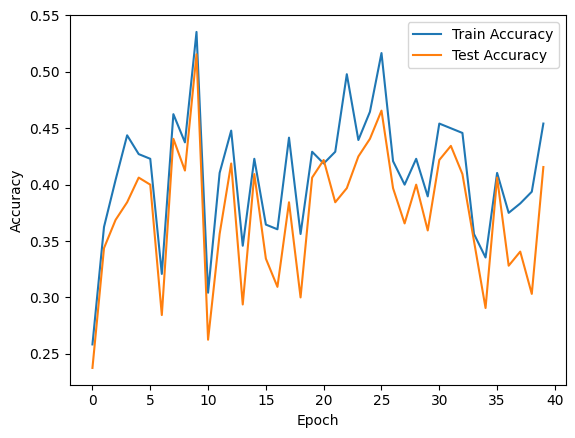

In [ ]:
plt.plot(train_epoch, train_acc, label='Train Accuracy')
plt.plot(train_epoch, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load best saved weights
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Model weights loaded successfully!")
else:
    print(f"No saved model found at {best_model_path}")

# Optionally set the model to evaluation mode if you are doing inference
model.eval()

<ipython-input-16-993b6eff0ea6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Model weights loaded successfully!


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

Testing: 100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Test Accuracy: 51.56%


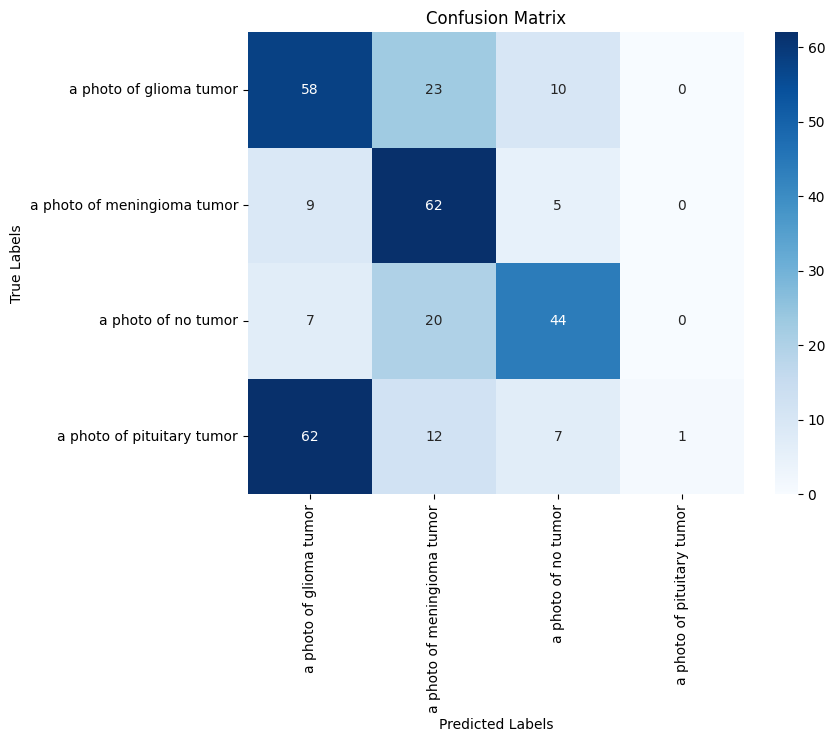

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, texts in tqdm(test_dataloader, desc="Testing"):
        images, texts = images.to(device), texts.to(device)
        input_text = clip.tokenize(text_prompts).to(device)



        # Forward pass (test mode)
        logits_per_image, logits_per_text = model(images, input_text)

        # Get predicted class (argmax over logits)
        preds = torch.argmax(logits_per_image, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(texts.cpu().numpy())

# accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=text_prompts, yticklabels=text_prompts)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
import numpy as np
import os

n_epochs = 25

train_acc = []
train_epoch = []
test_acc = []
train_loss = []

model.load_state_dict(torch.load("/content/drive/My Drive/Data/COL828/full_finetune_best_model_3.pth" ))


best_accuracy_sum = 0  # Variable to store the best combined accuracy
best_model_path = "/content/drive/My Drive/Data/COL828/partial_finetune_best_model_1.pth"  # Path to save the best model


for epoch in range(n_epochs):
    pbar = tqdm(train_dataloader, total = len(train_dataloader))
    loss=0
    model.train()
    for batch in pbar:
        optimizer.zero_grad()
        images, texts = batch
        images, texts = images.to(device), texts.to(device)

        # forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # loss is avg of text and image loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = loss_img(logits_per_image, ground_truth)

        total_loss.backward()
        loss+=total_loss.item()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)
        optimizer.step()

        pbar.set_description(f"Epoch {epoch}/{n_epochs}, Loss: {total_loss.item():.4f}")

    train_epoch.append(epoch)
    train_loss.append(loss/len(train_dataloader))
    print(f"Epoch {epoch}/{n_epochs}, Loss: {loss/len(train_dataloader):.4f}")


    epoch_pred = []
    epoch_label = []
    with torch.no_grad():
        model.eval()
        for images, texts in tqdm(test_dataloader_2, desc="Testing"):
            images, texts = images.to(device), texts.to(device)
            input_text = clip.tokenize(text_prompts).to(device)



            # Forward pass (test mode)
            logits_per_image, logits_per_text = model(images, input_text)

            # Get predicted class (argmax over logits)
            preds = torch.argmax(logits_per_image, dim=1)

            epoch_pred.extend(preds.cpu().numpy())
            epoch_label.extend(texts.cpu().numpy())
    accuracy = (np.array(epoch_pred) == np.array(epoch_label)).mean()
    train_acc.append(accuracy)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        model.eval()
        for images, texts in tqdm(test_dataloader, desc="Testing"):
            images, texts = images.to(device), texts.to(device)
            input_text = clip.tokenize(text_prompts).to(device)



            # Forward pass (test mode)
            logits_per_image, logits_per_text = model(images, input_text)

            # Get predicted class (argmax over logits)
            preds = torch.argmax(logits_per_image, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(texts.cpu().numpy())

            # accuracy
    accuracy_test = (np.array(all_preds) == np.array(all_labels)).mean()
    test_acc.append(accuracy_test)

    if accuracy_test > best_accuracy_sum:
        best_accuracy_sum = accuracy_test
        os.makedirs( "/content/drive/My Drive/Data/COL828", exist_ok=True)
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with combined accuracy {best_accuracy_sum * 100:.2f}%")



    print(f"Epoch {epoch}/{n_epochs}, Accuracy: {accuracy * 100:.2f}%, Test Accuracy: {accuracy_test*100:.2f}%")



Epoch 0/40, Loss: 2.2500: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Epoch 0/40, Loss: 2.3480


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Best model saved with combined accuracy 38.75%
Epoch 0/40, Accuracy: 45.42%, Test Accuracy: 38.75%


Epoch 1/40, Loss: 2.7559: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 1/40, Loss: 2.4426


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Best model saved with combined accuracy 57.50%
Epoch 1/40, Accuracy: 57.71%, Test Accuracy: 57.50%


Epoch 2/40, Loss: 2.4355: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 2/40, Loss: 2.3982


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Epoch 2/40, Accuracy: 45.83%, Test Accuracy: 41.56%


Epoch 3/40, Loss: 2.2695: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 3/40, Loss: 2.3176


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 3/40, Accuracy: 47.50%, Test Accuracy: 43.12%


Epoch 4/40, Loss: 2.2539: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Epoch 4/40, Loss: 2.3969


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


Epoch 4/40, Accuracy: 43.96%, Test Accuracy: 41.25%


Epoch 5/40, Loss: 2.2969: 100%|██████████| 15/15 [00:17<00:00,  1.13s/it]


Epoch 5/40, Loss: 2.3124


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Epoch 5/40, Accuracy: 38.54%, Test Accuracy: 34.38%


Epoch 6/40, Loss: 2.1680: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


Epoch 6/40, Loss: 2.2793


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Epoch 6/40, Accuracy: 42.92%, Test Accuracy: 41.25%


Epoch 7/40, Loss: 2.2422: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


Epoch 7/40, Loss: 2.2693


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch 7/40, Accuracy: 37.08%, Test Accuracy: 35.00%


Epoch 8/40, Loss: 2.3340: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 8/40, Loss: 2.2896


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


Epoch 8/40, Accuracy: 45.62%, Test Accuracy: 43.12%


Epoch 9/40, Loss: 2.4141: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 9/40, Loss: 2.2841


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch 9/40, Accuracy: 42.29%, Test Accuracy: 39.06%


Epoch 10/40, Loss: 2.2148: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 10/40, Loss: 2.2871


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch 10/40, Accuracy: 37.92%, Test Accuracy: 37.50%


Epoch 11/40, Loss: 2.2168: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 11/40, Loss: 2.2542


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


Epoch 11/40, Accuracy: 38.33%, Test Accuracy: 35.94%


Epoch 12/40, Loss: 2.2520: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 12/40, Loss: 2.2204


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch 12/40, Accuracy: 34.17%, Test Accuracy: 29.38%


Epoch 13/40, Loss: 2.3262: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 13/40, Loss: 2.3893


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 13/40, Accuracy: 39.79%, Test Accuracy: 37.50%


Epoch 14/40, Loss: 2.1230: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 14/40, Loss: 2.2201


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch 14/40, Accuracy: 42.92%, Test Accuracy: 39.06%


Epoch 15/40, Loss: 2.4668: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 15/40, Loss: 2.2711


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 15/40, Accuracy: 40.83%, Test Accuracy: 39.69%


Epoch 16/40, Loss: 2.3262: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 16/40, Loss: 2.3453


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 16/40, Accuracy: 34.79%, Test Accuracy: 32.50%


Epoch 17/40, Loss: 2.3164: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 17/40, Loss: 2.2361


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Epoch 17/40, Accuracy: 43.12%, Test Accuracy: 41.88%


Epoch 18/40, Loss: 2.1230: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 18/40, Loss: 2.2232


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch 18/40, Accuracy: 34.79%, Test Accuracy: 28.12%


Epoch 19/40, Loss: 2.4355: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 19/40, Loss: 2.3397


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch 19/40, Accuracy: 44.38%, Test Accuracy: 40.00%


Epoch 20/40, Loss: 2.1562: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 20/40, Loss: 2.2281


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Epoch 20/40, Accuracy: 39.17%, Test Accuracy: 33.75%


Epoch 21/40, Loss: 2.1211: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 21/40, Loss: 2.2204


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Epoch 21/40, Accuracy: 41.25%, Test Accuracy: 38.12%


Epoch 22/40, Loss: 2.3340: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 22/40, Loss: 2.1879


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Epoch 22/40, Accuracy: 40.42%, Test Accuracy: 38.44%


Epoch 23/40, Loss: 2.2266: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 23/40, Loss: 2.2385


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Epoch 23/40, Accuracy: 37.92%, Test Accuracy: 35.94%


Epoch 24/40, Loss: 2.2188: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 24/40, Loss: 2.2103


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch 24/40, Accuracy: 38.12%, Test Accuracy: 36.25%


Epoch 25/40, Loss: 2.1602: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 25/40, Loss: 2.1725


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Epoch 25/40, Accuracy: 34.58%, Test Accuracy: 33.44%


Epoch 26/40, Loss: 2.1777: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 26/40, Loss: 2.1693


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Epoch 26/40, Accuracy: 42.71%, Test Accuracy: 38.12%


Epoch 27/40, Loss: 2.1855: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 27/40, Loss: 2.1928


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Epoch 27/40, Accuracy: 35.00%, Test Accuracy: 30.63%


Epoch 28/40, Loss: 2.1621: 100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 28/40, Loss: 2.2526


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch 28/40, Accuracy: 33.54%, Test Accuracy: 30.94%


Epoch 29/40, Loss: 2.2480: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 29/40, Loss: 2.1855


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch 29/40, Accuracy: 38.75%, Test Accuracy: 37.19%


Epoch 30/40, Loss: 2.2988: 100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 30/40, Loss: 2.3159


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Epoch 30/40, Accuracy: 36.04%, Test Accuracy: 33.12%


Epoch 31/40, Loss: 2.3789: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Epoch 31/40, Loss: 2.3526


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 31/40, Accuracy: 42.08%, Test Accuracy: 35.31%


Epoch 32/40, Loss: 2.1973: 100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 32/40, Loss: 2.2598


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Epoch 32/40, Accuracy: 33.75%, Test Accuracy: 28.75%


Epoch 33/40, Loss: 2.1758: 100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


Epoch 33/40, Loss: 2.2419


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Epoch 33/40, Accuracy: 33.33%, Test Accuracy: 31.25%


Epoch 34/40, Loss: 2.2852: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 34/40, Loss: 2.2135


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Epoch 34/40, Accuracy: 31.67%, Test Accuracy: 26.88%


Epoch 35/40, Loss: 2.1484: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 35/40, Loss: 2.1943


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Epoch 35/40, Accuracy: 40.83%, Test Accuracy: 34.06%


Epoch 36/40, Loss: 2.1211: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Epoch 36/40, Loss: 2.1546


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch 36/40, Accuracy: 44.79%, Test Accuracy: 41.25%


Epoch 37/40, Loss: 2.1094: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


Epoch 37/40, Loss: 2.1458


Testing: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Epoch 37/40, Accuracy: 36.04%, Test Accuracy: 35.62%


Epoch 38/40, Loss: 2.1172: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Epoch 38/40, Loss: 2.1553


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch 38/40, Accuracy: 37.71%, Test Accuracy: 37.81%


Epoch 39/40, Loss: 2.0996: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 39/40, Loss: 2.2174


Testing: 100%|██████████| 10/10 [00:02<00:00,  4.90it/s]

Epoch 39/40, Accuracy: 40.21%, Test Accuracy: 40.62%


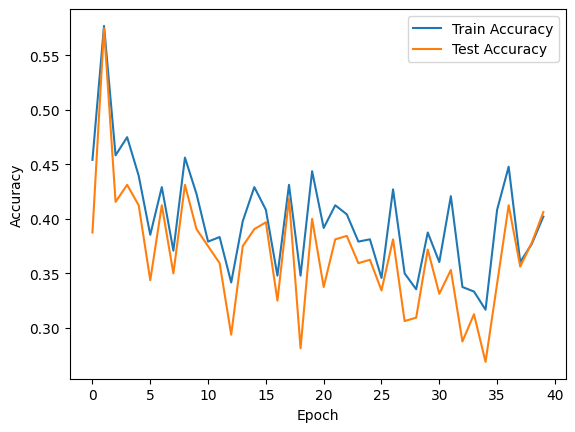

In [ ]:
plt.plot(train_epoch, train_acc, label='Train Accuracy')
plt.plot(train_epoch, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<ipython-input-20-88b4a7e49417>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/partial_finetune_best

Test Accuracy: 57.50%


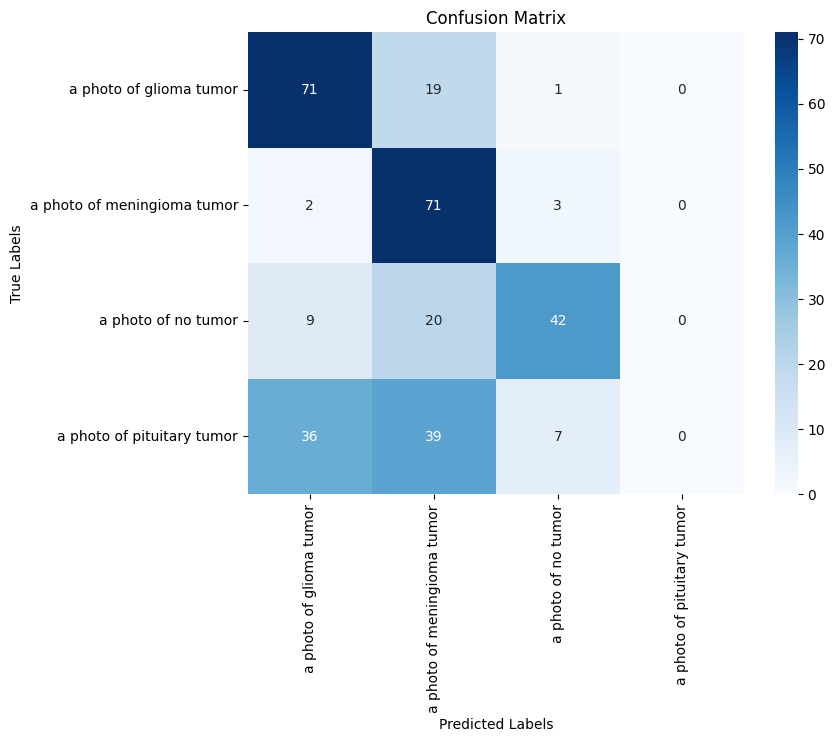

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


model.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/partial_finetune_best_model_1.pth"))


model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, texts in tqdm(test_dataloader, desc="Testing"):
        images, texts = images.to(device), texts.to(device)
        input_text = clip.tokenize(text_prompts).to(device)



        # Forward pass (test mode)
        logits_per_image, logits_per_text = model(images, input_text)

        # Get predicted class (argmax over logits)
        preds = torch.argmax(logits_per_image, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(texts.cpu().numpy())

# accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=text_prompts, yticklabels=text_prompts)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [ ]:
model.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/partial_finetune_best_model_1.pth"))



<ipython-input-26-60ae09f936e6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/partial_finetune_best

<All keys matched successfully>

In [ ]:
model_ft = CLIPFineTuner(model, 4).to(device)

# Finetunning only classifier

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

Epoch 1/50, Loss: 1.3811: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Epoch [1/50], Loss: 1.3811, Training Accuracy: 27.29%
Validation Accuracy: 36.88%
Best model saved with accuracy 36.88%


Epoch 2/50, Loss: 1.3392: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch [2/50], Loss: 1.3392, Training Accuracy: 38.75%
Validation Accuracy: 44.06%
Best model saved with accuracy 44.06%


Epoch 3/50, Loss: 1.3036: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Epoch [3/50], Loss: 1.3036, Training Accuracy: 46.46%
Validation Accuracy: 53.12%
Best model saved with accuracy 53.12%


Epoch 4/50, Loss: 1.2723: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch [4/50], Loss: 1.2723, Training Accuracy: 55.21%
Validation Accuracy: 60.94%
Best model saved with accuracy 60.94%


Epoch 5/50, Loss: 1.2439: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]


Epoch [5/50], Loss: 1.2439, Training Accuracy: 62.92%
Validation Accuracy: 62.19%
Best model saved with accuracy 62.19%


Epoch 6/50, Loss: 1.2176: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch [6/50], Loss: 1.2176, Training Accuracy: 66.46%
Validation Accuracy: 65.00%
Best model saved with accuracy 65.00%


Epoch 7/50, Loss: 1.1930: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


Epoch [7/50], Loss: 1.1930, Training Accuracy: 68.33%
Validation Accuracy: 65.62%
Best model saved with accuracy 65.62%


Epoch 8/50, Loss: 1.1699: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch [8/50], Loss: 1.1699, Training Accuracy: 69.79%
Validation Accuracy: 66.56%
Best model saved with accuracy 66.56%


Epoch 9/50, Loss: 1.1481: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


Epoch [9/50], Loss: 1.1481, Training Accuracy: 70.00%
Validation Accuracy: 68.12%
Best model saved with accuracy 68.12%


Epoch 10/50, Loss: 1.1275: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [10/50], Loss: 1.1275, Training Accuracy: 71.04%
Validation Accuracy: 69.06%
Best model saved with accuracy 69.06%


Epoch 11/50, Loss: 1.1080: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


Epoch [11/50], Loss: 1.1080, Training Accuracy: 71.67%
Validation Accuracy: 69.69%
Best model saved with accuracy 69.69%


Epoch 12/50, Loss: 1.0896: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch [12/50], Loss: 1.0896, Training Accuracy: 72.29%
Validation Accuracy: 69.69%


Epoch 13/50, Loss: 1.0722: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch [13/50], Loss: 1.0722, Training Accuracy: 72.71%
Validation Accuracy: 70.94%
Best model saved with accuracy 70.94%


Epoch 14/50, Loss: 1.0557: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


Epoch [14/50], Loss: 1.0557, Training Accuracy: 72.92%
Validation Accuracy: 70.62%


Epoch 15/50, Loss: 1.0400: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [15/50], Loss: 1.0400, Training Accuracy: 73.75%
Validation Accuracy: 71.88%
Best model saved with accuracy 71.88%


Epoch 16/50, Loss: 1.0252: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Epoch [16/50], Loss: 1.0252, Training Accuracy: 73.33%
Validation Accuracy: 72.19%
Best model saved with accuracy 72.19%


Epoch 17/50, Loss: 1.0110: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


Epoch [17/50], Loss: 1.0110, Training Accuracy: 72.92%
Validation Accuracy: 73.44%
Best model saved with accuracy 73.44%


Epoch 18/50, Loss: 0.9976: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Epoch [18/50], Loss: 0.9976, Training Accuracy: 73.12%
Validation Accuracy: 73.75%
Best model saved with accuracy 73.75%


Epoch 19/50, Loss: 0.9848: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


Epoch [19/50], Loss: 0.9848, Training Accuracy: 73.54%
Validation Accuracy: 74.06%
Best model saved with accuracy 74.06%


Epoch 20/50, Loss: 0.9726: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch [20/50], Loss: 0.9726, Training Accuracy: 73.54%
Validation Accuracy: 74.06%


Epoch 21/50, Loss: 0.9610: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]


Epoch [21/50], Loss: 0.9610, Training Accuracy: 73.75%
Validation Accuracy: 74.38%
Best model saved with accuracy 74.38%


Epoch 22/50, Loss: 0.9499: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


Epoch [22/50], Loss: 0.9499, Training Accuracy: 74.17%
Validation Accuracy: 74.38%


Epoch 23/50, Loss: 0.9393: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


Epoch [23/50], Loss: 0.9393, Training Accuracy: 74.38%
Validation Accuracy: 74.38%


Epoch 24/50, Loss: 0.9291: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch [24/50], Loss: 0.9291, Training Accuracy: 74.38%
Validation Accuracy: 74.38%


Epoch 25/50, Loss: 0.9194: 100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


Epoch [25/50], Loss: 0.9194, Training Accuracy: 74.79%
Validation Accuracy: 74.69%
Best model saved with accuracy 74.69%


Epoch 26/50, Loss: 0.9100: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Epoch [26/50], Loss: 0.9100, Training Accuracy: 75.62%
Validation Accuracy: 74.38%


Epoch 27/50, Loss: 0.9010: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch [27/50], Loss: 0.9010, Training Accuracy: 75.62%
Validation Accuracy: 74.38%


Epoch 28/50, Loss: 0.8924: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Epoch [28/50], Loss: 0.8924, Training Accuracy: 75.83%
Validation Accuracy: 74.06%


Epoch 29/50, Loss: 0.8841: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [29/50], Loss: 0.8841, Training Accuracy: 75.83%
Validation Accuracy: 74.06%


Epoch 30/50, Loss: 0.8761: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch [30/50], Loss: 0.8761, Training Accuracy: 76.25%
Validation Accuracy: 73.75%


Epoch 31/50, Loss: 0.8684: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch [31/50], Loss: 0.8684, Training Accuracy: 76.46%
Validation Accuracy: 73.75%


Epoch 32/50, Loss: 0.8610: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch [32/50], Loss: 0.8610, Training Accuracy: 76.25%
Validation Accuracy: 73.75%


Epoch 33/50, Loss: 0.8539: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


Epoch [33/50], Loss: 0.8539, Training Accuracy: 76.46%
Validation Accuracy: 73.75%


Epoch 34/50, Loss: 0.8469: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


Epoch [34/50], Loss: 0.8469, Training Accuracy: 76.88%
Validation Accuracy: 74.38%


Epoch 35/50, Loss: 0.8402: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch [35/50], Loss: 0.8402, Training Accuracy: 77.29%
Validation Accuracy: 74.06%


Epoch 36/50, Loss: 0.8338: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [36/50], Loss: 0.8338, Training Accuracy: 77.29%
Validation Accuracy: 74.06%


Epoch 37/50, Loss: 0.8275: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch [37/50], Loss: 0.8275, Training Accuracy: 77.71%
Validation Accuracy: 74.06%


Epoch 38/50, Loss: 0.8214: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


Epoch [38/50], Loss: 0.8214, Training Accuracy: 77.92%
Validation Accuracy: 74.38%


Epoch 39/50, Loss: 0.8155: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch [39/50], Loss: 0.8155, Training Accuracy: 77.92%
Validation Accuracy: 74.38%


Epoch 40/50, Loss: 0.8098: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Epoch [40/50], Loss: 0.8098, Training Accuracy: 77.71%
Validation Accuracy: 74.38%


Epoch 41/50, Loss: 0.8043: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch [41/50], Loss: 0.8043, Training Accuracy: 77.50%
Validation Accuracy: 74.38%


Epoch 42/50, Loss: 0.7989: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [42/50], Loss: 0.7989, Training Accuracy: 77.71%
Validation Accuracy: 74.38%


Epoch 43/50, Loss: 0.7936: 100%|██████████| 15/15 [00:03<00:00,  4.33it/s]


Epoch [43/50], Loss: 0.7936, Training Accuracy: 77.50%
Validation Accuracy: 74.38%


Epoch 44/50, Loss: 0.7885: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [44/50], Loss: 0.7885, Training Accuracy: 77.71%
Validation Accuracy: 74.69%


Epoch 45/50, Loss: 0.7836: 100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


Epoch [45/50], Loss: 0.7836, Training Accuracy: 77.50%
Validation Accuracy: 75.31%
Best model saved with accuracy 75.31%


Epoch 46/50, Loss: 0.7787: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch [46/50], Loss: 0.7787, Training Accuracy: 77.29%
Validation Accuracy: 75.31%


Epoch 47/50, Loss: 0.7740: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Epoch [47/50], Loss: 0.7740, Training Accuracy: 77.71%
Validation Accuracy: 75.31%


Epoch 48/50, Loss: 0.7694: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


Epoch [48/50], Loss: 0.7694, Training Accuracy: 77.92%
Validation Accuracy: 76.25%
Best model saved with accuracy 76.25%


Epoch 49/50, Loss: 0.7649: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


Epoch [49/50], Loss: 0.7649, Training Accuracy: 78.12%
Validation Accuracy: 76.25%


Epoch 50/50, Loss: 0.7605: 100%|██████████| 15/15 [00:03<00:00,  4.25it/s]


Epoch [50/50], Loss: 0.7605, Training Accuracy: 78.12%
Validation Accuracy: 76.25%


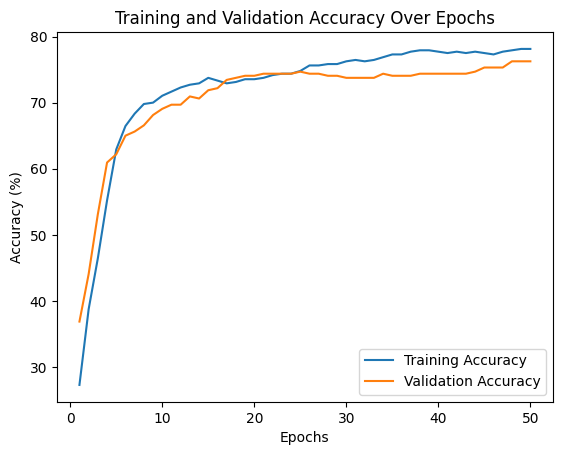

In [ ]:
from tqdm import tqdm
import torch
import os

# Number of epochs for training
num_epochs = 50

best_accuracy = 0

best_model_path = "/content/drive/My Drive/Data/COL828/classifier_finetune_best_model_1.pth"

train_acc = []
test_acc = []
epoches = []

# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model

        # Update pred_label and true_label
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        pred_label.extend(predicted.cpu().numpy())  # Store predictions
        true_label.extend(labels.cpu().numpy())  # Store true labels

        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}")  # Update progress bar with current loss

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)

    print(f'Validation Accuracy: {accuracy_test:.2f}%')  # Print validation accuracy for the epoch

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/content/drive/My Drive/Data/COL828", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

# Optionally, you can visualize the accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


Epoch 1/20, Loss: 0.7563: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Epoch [1/20], Loss: 0.7563, Training Accuracy: 78.33%
Validation Accuracy: 76.25%


Epoch 2/20, Loss: 0.7521: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Epoch [2/20], Loss: 0.7521, Training Accuracy: 78.54%
Validation Accuracy: 76.56%
Best model saved with accuracy 76.56%


Epoch 3/20, Loss: 0.7480: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch [3/20], Loss: 0.7480, Training Accuracy: 78.54%
Validation Accuracy: 76.56%


Epoch 4/20, Loss: 0.7440: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Epoch [4/20], Loss: 0.7440, Training Accuracy: 78.54%
Validation Accuracy: 76.56%


Epoch 5/20, Loss: 0.7401: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Epoch [5/20], Loss: 0.7401, Training Accuracy: 78.75%
Validation Accuracy: 76.56%


Epoch 6/20, Loss: 0.7363: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch [6/20], Loss: 0.7363, Training Accuracy: 78.96%
Validation Accuracy: 76.56%


Epoch 7/20, Loss: 0.7326: 100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


Epoch [7/20], Loss: 0.7326, Training Accuracy: 78.96%
Validation Accuracy: 76.56%


Epoch 8/20, Loss: 0.7289: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


Epoch [8/20], Loss: 0.7289, Training Accuracy: 79.17%
Validation Accuracy: 76.56%


Epoch 9/20, Loss: 0.7254: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]


Epoch [9/20], Loss: 0.7254, Training Accuracy: 79.17%
Validation Accuracy: 76.56%


Epoch 10/20, Loss: 0.7218: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Epoch [10/20], Loss: 0.7218, Training Accuracy: 79.17%
Validation Accuracy: 76.56%


Epoch 11/20, Loss: 0.7184: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Epoch [11/20], Loss: 0.7184, Training Accuracy: 79.17%
Validation Accuracy: 76.56%


Epoch 12/20, Loss: 0.7150: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch [12/20], Loss: 0.7150, Training Accuracy: 79.38%
Validation Accuracy: 76.56%


Epoch 13/20, Loss: 0.7117: 100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch [13/20], Loss: 0.7117, Training Accuracy: 79.38%
Validation Accuracy: 76.56%


Epoch 14/20, Loss: 0.7085: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


Epoch [14/20], Loss: 0.7085, Training Accuracy: 79.38%
Validation Accuracy: 76.56%


Epoch 15/20, Loss: 0.7053: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


Epoch [15/20], Loss: 0.7053, Training Accuracy: 79.38%
Validation Accuracy: 76.56%


Epoch 16/20, Loss: 0.7022: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Epoch [16/20], Loss: 0.7022, Training Accuracy: 79.58%
Validation Accuracy: 76.56%


Epoch 17/20, Loss: 0.6991: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]


Epoch [17/20], Loss: 0.6991, Training Accuracy: 79.58%
Validation Accuracy: 76.56%


Epoch 18/20, Loss: 0.6961: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Epoch [18/20], Loss: 0.6961, Training Accuracy: 79.58%
Validation Accuracy: 76.56%


Epoch 19/20, Loss: 0.6931: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch [19/20], Loss: 0.6931, Training Accuracy: 79.58%
Validation Accuracy: 76.56%


Epoch 20/20, Loss: 0.6902: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Epoch [20/20], Loss: 0.6902, Training Accuracy: 79.79%
Validation Accuracy: 76.25%


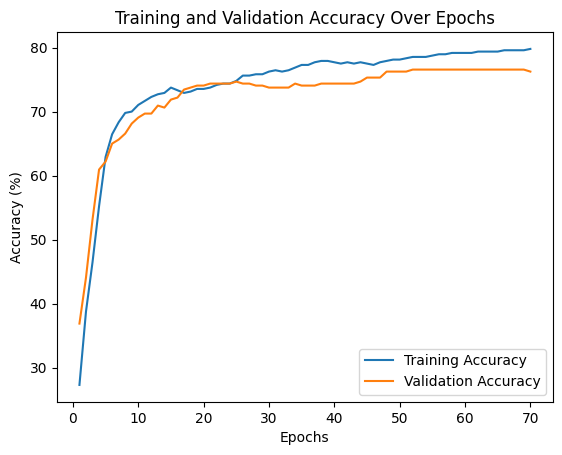

In [ ]:
from tqdm import tqdm
import torch
import os

# Number of epochs for training
num_epochs = 20

best_model_path = "/content/drive/My Drive/Data/COL828/classifier_finetune_best_model_2.pth"

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model

        # Update pred_label and true_label
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        pred_label.extend(predicted.cpu().numpy())  # Store predictions
        true_label.extend(labels.cpu().numpy())  # Store true labels

        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}")  # Update progress bar with current loss

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 51)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)

    print(f'Validation Accuracy: {accuracy_test:.2f}%')  # Print validation accuracy for the epoch

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/content/drive/My Drive/Data/COL828", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

# Optionally, you can visualize the accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


In [ ]:
model_ft.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/classifier_finetune_best_model_2.pth"))

<ipython-input-32-1bf8e4bf654d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/classifier_finetun

<All keys matched successfully>

Test Accuracy: 76.56%


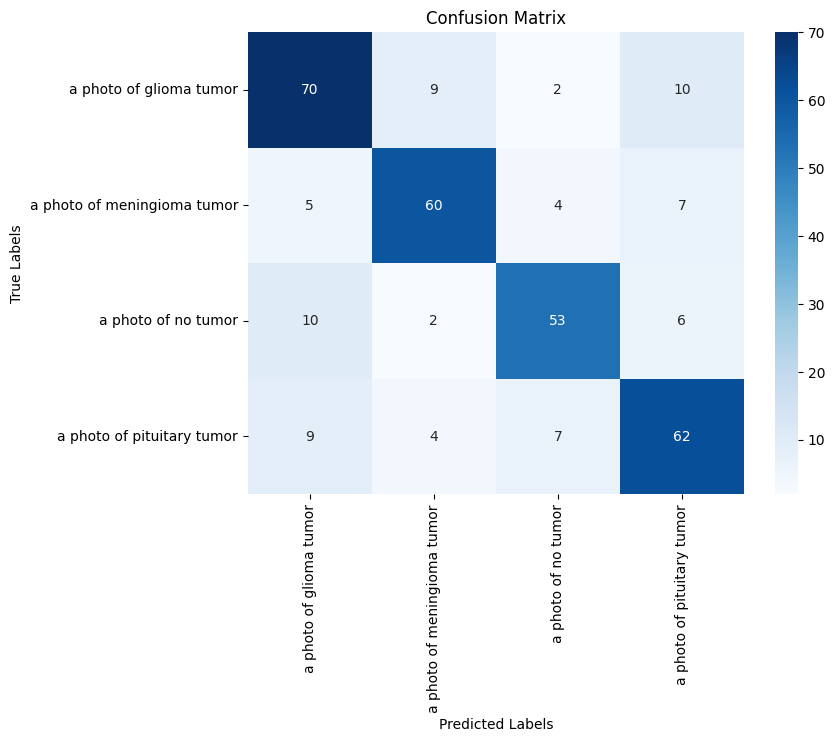

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



model_ft.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():  # Disable gradient calculation for validation
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
          outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
          _, predicted = torch.max(outputs.data, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

# accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=text_prompts, yticklabels=text_prompts)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Full Fine Tunning

In [ ]:
model.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/partial_finetune_best_model_1.pth"))

<ipython-input-34-24c4d3f534a9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load( "/content/drive/My Drive/Data/COL828/partial_finetune_best

<All keys matched successfully>

In [ ]:
model_ft = CLIPFineTuner(model, 4).to(device)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

Epoch 1/50, Loss: 1.3607: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Epoch [1/50], Loss: 1.3607, Training Accuracy: 33.54%
Validation Accuracy: 35.62%
Best model saved with accuracy 35.62%


Epoch 2/50, Loss: 1.3199: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


Epoch [2/50], Loss: 1.3199, Training Accuracy: 45.62%
Validation Accuracy: 46.56%
Best model saved with accuracy 46.56%


Epoch 3/50, Loss: 1.2856: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Epoch [3/50], Loss: 1.2856, Training Accuracy: 52.92%
Validation Accuracy: 53.12%
Best model saved with accuracy 53.12%


Epoch 4/50, Loss: 1.2557: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch [4/50], Loss: 1.2557, Training Accuracy: 63.33%
Validation Accuracy: 63.44%
Best model saved with accuracy 63.44%


Epoch 5/50, Loss: 1.2287: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]


Epoch [5/50], Loss: 1.2287, Training Accuracy: 70.00%
Validation Accuracy: 69.06%
Best model saved with accuracy 69.06%


Epoch 6/50, Loss: 1.2036: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Epoch [6/50], Loss: 1.2036, Training Accuracy: 69.17%
Validation Accuracy: 69.06%


Epoch 7/50, Loss: 1.1801: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]


Epoch [7/50], Loss: 1.1801, Training Accuracy: 70.62%
Validation Accuracy: 69.06%


Epoch 8/50, Loss: 1.1580: 100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


Epoch [8/50], Loss: 1.1580, Training Accuracy: 72.08%
Validation Accuracy: 70.00%
Best model saved with accuracy 70.00%


Epoch 9/50, Loss: 1.1371: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [9/50], Loss: 1.1371, Training Accuracy: 71.67%
Validation Accuracy: 70.00%


Epoch 10/50, Loss: 1.1173: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


Epoch [10/50], Loss: 1.1173, Training Accuracy: 72.50%
Validation Accuracy: 70.62%
Best model saved with accuracy 70.62%


Epoch 11/50, Loss: 1.0986: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch [11/50], Loss: 1.0986, Training Accuracy: 73.33%
Validation Accuracy: 70.31%


Epoch 12/50, Loss: 1.0808: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


Epoch [12/50], Loss: 1.0808, Training Accuracy: 73.54%
Validation Accuracy: 70.62%


Epoch 13/50, Loss: 1.0640: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Epoch [13/50], Loss: 1.0640, Training Accuracy: 74.17%
Validation Accuracy: 70.31%


Epoch 14/50, Loss: 1.0480: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch [14/50], Loss: 1.0480, Training Accuracy: 75.21%
Validation Accuracy: 70.00%


Epoch 15/50, Loss: 1.0329: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


Epoch [15/50], Loss: 1.0329, Training Accuracy: 75.42%
Validation Accuracy: 70.62%


Epoch 16/50, Loss: 1.0184: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch [16/50], Loss: 1.0184, Training Accuracy: 76.25%
Validation Accuracy: 71.25%
Best model saved with accuracy 71.25%


Epoch 17/50, Loss: 1.0047: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Epoch [17/50], Loss: 1.0047, Training Accuracy: 77.08%
Validation Accuracy: 71.88%
Best model saved with accuracy 71.88%


Epoch 18/50, Loss: 0.9917: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch [18/50], Loss: 0.9917, Training Accuracy: 77.50%
Validation Accuracy: 72.19%
Best model saved with accuracy 72.19%


Epoch 19/50, Loss: 0.9792: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Epoch [19/50], Loss: 0.9792, Training Accuracy: 77.29%
Validation Accuracy: 72.50%
Best model saved with accuracy 72.50%


Epoch 20/50, Loss: 0.9673: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch [20/50], Loss: 0.9673, Training Accuracy: 77.92%
Validation Accuracy: 72.81%
Best model saved with accuracy 72.81%


Epoch 21/50, Loss: 0.9560: 100%|██████████| 15/15 [00:03<00:00,  4.19it/s]


Epoch [21/50], Loss: 0.9560, Training Accuracy: 78.12%
Validation Accuracy: 73.44%
Best model saved with accuracy 73.44%


Epoch 22/50, Loss: 0.9451: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch [22/50], Loss: 0.9451, Training Accuracy: 78.12%
Validation Accuracy: 73.12%


Epoch 23/50, Loss: 0.9347: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Epoch [23/50], Loss: 0.9347, Training Accuracy: 77.92%
Validation Accuracy: 73.75%
Best model saved with accuracy 73.75%


Epoch 24/50, Loss: 0.9248: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Epoch [24/50], Loss: 0.9248, Training Accuracy: 77.92%
Validation Accuracy: 73.75%


Epoch 25/50, Loss: 0.9152: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch [25/50], Loss: 0.9152, Training Accuracy: 77.50%
Validation Accuracy: 73.75%


Epoch 26/50, Loss: 0.9060: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Epoch [26/50], Loss: 0.9060, Training Accuracy: 78.33%
Validation Accuracy: 73.75%


Epoch 27/50, Loss: 0.8972: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch [27/50], Loss: 0.8972, Training Accuracy: 78.12%
Validation Accuracy: 74.06%
Best model saved with accuracy 74.06%


Epoch 28/50, Loss: 0.8888: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Epoch [28/50], Loss: 0.8888, Training Accuracy: 77.92%
Validation Accuracy: 73.75%


Epoch 29/50, Loss: 0.8806: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Epoch [29/50], Loss: 0.8806, Training Accuracy: 77.92%
Validation Accuracy: 74.06%


Epoch 30/50, Loss: 0.8728: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Epoch [30/50], Loss: 0.8728, Training Accuracy: 77.92%
Validation Accuracy: 74.38%
Best model saved with accuracy 74.38%


Epoch 31/50, Loss: 0.8652: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch [31/50], Loss: 0.8652, Training Accuracy: 77.92%
Validation Accuracy: 74.69%
Best model saved with accuracy 74.69%


Epoch 32/50, Loss: 0.8579: 100%|██████████| 15/15 [00:03<00:00,  4.39it/s]


Epoch [32/50], Loss: 0.8579, Training Accuracy: 77.92%
Validation Accuracy: 74.69%


Epoch 33/50, Loss: 0.8508: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Epoch [33/50], Loss: 0.8508, Training Accuracy: 77.92%
Validation Accuracy: 75.00%
Best model saved with accuracy 75.00%


Epoch 34/50, Loss: 0.8440: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


Epoch [34/50], Loss: 0.8440, Training Accuracy: 77.92%
Validation Accuracy: 75.31%
Best model saved with accuracy 75.31%


Epoch 35/50, Loss: 0.8374: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Epoch [35/50], Loss: 0.8374, Training Accuracy: 77.92%
Validation Accuracy: 75.31%


Epoch 36/50, Loss: 0.8310: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch [36/50], Loss: 0.8310, Training Accuracy: 78.12%
Validation Accuracy: 75.31%


Epoch 37/50, Loss: 0.8248: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch [37/50], Loss: 0.8248, Training Accuracy: 78.33%
Validation Accuracy: 75.31%


Epoch 38/50, Loss: 0.8188: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch [38/50], Loss: 0.8188, Training Accuracy: 78.54%
Validation Accuracy: 75.31%


Epoch 39/50, Loss: 0.8130: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Epoch [39/50], Loss: 0.8130, Training Accuracy: 78.54%
Validation Accuracy: 75.62%
Best model saved with accuracy 75.62%


Epoch 40/50, Loss: 0.8074: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch [40/50], Loss: 0.8074, Training Accuracy: 78.54%
Validation Accuracy: 75.94%
Best model saved with accuracy 75.94%


Epoch 41/50, Loss: 0.8019: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


Epoch [41/50], Loss: 0.8019, Training Accuracy: 78.54%
Validation Accuracy: 75.94%


Epoch 42/50, Loss: 0.7965: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


Epoch [42/50], Loss: 0.7965, Training Accuracy: 78.54%
Validation Accuracy: 76.25%
Best model saved with accuracy 76.25%


Epoch 43/50, Loss: 0.7914: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]


Epoch [43/50], Loss: 0.7914, Training Accuracy: 78.54%
Validation Accuracy: 76.25%


Epoch 44/50, Loss: 0.7863: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch [44/50], Loss: 0.7863, Training Accuracy: 78.54%
Validation Accuracy: 76.25%


Epoch 45/50, Loss: 0.7814: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Epoch [45/50], Loss: 0.7814, Training Accuracy: 78.54%
Validation Accuracy: 76.25%


Epoch 46/50, Loss: 0.7766: 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]


Epoch [46/50], Loss: 0.7766, Training Accuracy: 78.54%
Validation Accuracy: 75.94%


Epoch 47/50, Loss: 0.7719: 100%|██████████| 15/15 [00:03<00:00,  4.31it/s]


Epoch [47/50], Loss: 0.7719, Training Accuracy: 78.54%
Validation Accuracy: 75.94%


Epoch 48/50, Loss: 0.7674: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Epoch [48/50], Loss: 0.7674, Training Accuracy: 78.75%
Validation Accuracy: 75.62%


Epoch 49/50, Loss: 0.7630: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch [49/50], Loss: 0.7630, Training Accuracy: 78.96%
Validation Accuracy: 75.62%


Epoch 50/50, Loss: 0.7586: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Epoch [50/50], Loss: 0.7586, Training Accuracy: 78.96%
Validation Accuracy: 75.62%


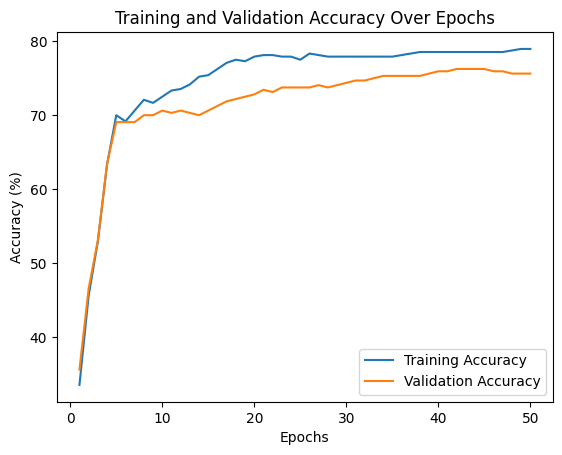

In [ ]:
from tqdm import tqdm
import torch
import os

# Number of epochs for training
num_epochs = 50

best_accuracy = 0

best_model_path = "/content/drive/My Drive/Data/COL828/full_with_classifer_finetune_best_model_1.pth"

train_acc = []
test_acc = []
epoches = []

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(test_dataloader_2, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    pred_label = []
    true_label = []

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model

        # Update pred_label and true_label
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        pred_label.extend(predicted.cpu().numpy())  # Store predictions
        true_label.extend(labels.cpu().numpy())  # Store true labels

        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(test_dataloader_2):.4f}")  # Update progress bar with current loss

    # Calculate and print training accuracy
    train_correct = sum(p == t for p, t in zip(pred_label, true_label))
    train_accuracy = 100 * train_correct / len(true_label)
    train_acc.append(train_accuracy)
    epoches.append(epoch + 1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(test_dataloader_2):.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    accuracy_test = 100 * correct / total
    test_acc.append(accuracy_test)

    print(f'Validation Accuracy: {accuracy_test:.2f}%')  # Print validation accuracy for the epoch

    # Save best model if the validation accuracy improves
    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        os.makedirs( "/content/drive/My Drive/Data/COL828", exist_ok=True)
        torch.save(model_ft.state_dict(), best_model_path)
        print(f"Best model saved with accuracy {best_accuracy:.2f}%")

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

# Optionally, you can visualize the accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(epoches, train_acc, label='Training Accuracy')
plt.plot(epoches, test_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()


<ipython-input-39-b99c17217a7d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("/content/drive/My Drive/Data/COL828/full_with_classifer

Test Accuracy: 76.25%


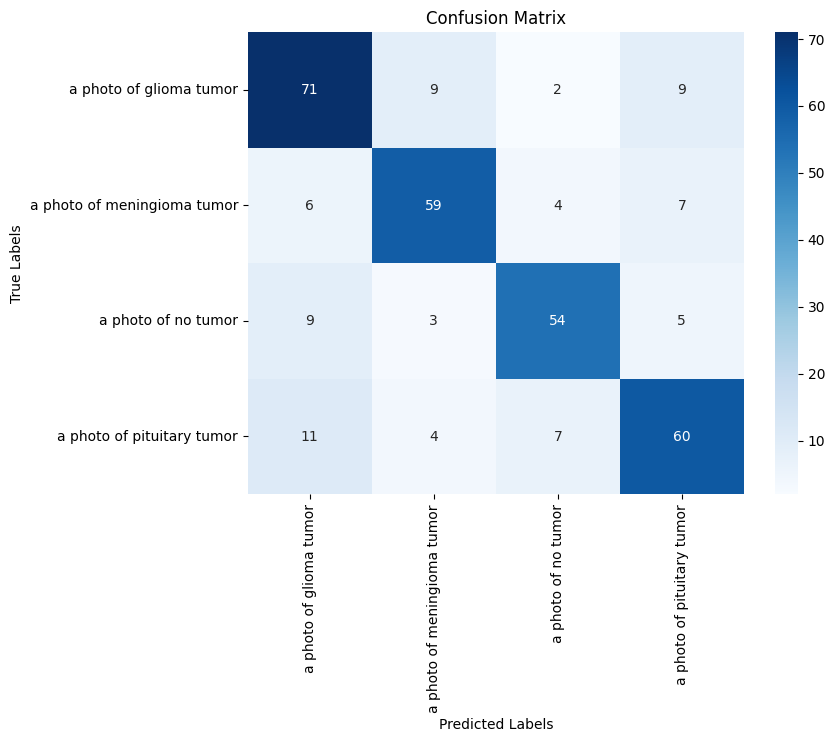

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model_ft.load_state_dict(torch.load("/content/drive/My Drive/Data/COL828/full_with_classifer_finetune_best_model_1.pth"))

model_ft.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

test_dataset = CustomImageDataset(ds["test"]["image"], ds["test"]["label"])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():  # Disable gradient calculation for validation
      for images, labels in test_dataloader:
          images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
          outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
          _, predicted = torch.max(outputs.data, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

# accuracy
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=text_prompts, yticklabels=text_prompts)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
